In [15]:
# Install dependencies
!pip install git+https://github.com/openai/whisper.git -q
!pip install sentence-transformers scikit-learn librosa -q

In [2]:
#Import required libraries
import os
import pandas as pd
import whisper
import librosa
import numpy as np
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr

import matplotlib.pyplot as plt

In [3]:
#Load Data & Whisper Model
train_df = pd.read_csv("/content/drive/MyDrive/shl-data/dataset/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/shl-data/dataset/test.csv")

TRAIN_AUDIO_DIR = "/content/drive/MyDrive/shl-data/dataset/audios_train"
TEST_AUDIO_DIR = "/content/drive/MyDrive/shl-data/dataset/audios_test"
whisper_model = whisper.load_model("small")  # Options: tiny, base, small, medium, large


100%|███████████████████████████████████████| 461M/461M [00:11<00:00, 41.2MiB/s]


In [4]:
#Transcribe Audio
def transcribe_audio(path):
    result = whisper_model.transcribe(path)
    return result["text"]

train_transcripts = []
for fname in tqdm(train_df["filename"], desc="Transcribing train audio"):
    audio_path = os.path.join(TRAIN_AUDIO_DIR, fname)
    text = transcribe_audio(audio_path)
    train_transcripts.append(text)

train_df["transcript"] = train_transcripts

Transcribing train audio: 100%|██████████| 444/444 [1:50:33<00:00, 14.94s/it]


In [6]:
# STEP 6: Sentence-BERT Embeddings
embedder = SentenceTransformer("all-MiniLM-L6-v2")
X_train = embedder.encode(train_df["transcript"].tolist(), show_progress_bar=True)
y_train = train_df["label"].values


Batches:   0%|          | 0/14 [00:00<?, ?it/s]

In [7]:
# STEP 7: Define Models
ridge = Ridge(alpha=1.0)
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
lgb = LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)


In [8]:
# STEP 8: Cross-Validation Evaluation
from sklearn.model_selection import KFold

def evaluate_model(name, model):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    y_pred = cross_val_predict(model, X_train, y_train, cv=kf)
    r = pearsonr(y_train, y_pred)[0]
    print(f"{name} Pearson: {r:.4f}")
    return y_pred, r

ridge_pred, r_ridge = evaluate_model("Ridge", ridge)
xgb_pred, r_xgb = evaluate_model("XGBoost", xgb)
lgb_pred, r_lgb = evaluate_model("LightGBM", lgb)

# Ensemble prediction (simple average)
ensemble_pred = (ridge_pred + xgb_pred + lgb_pred) / 3
r_ensemble = pearsonr(y_train, ensemble_pred)[0]
print(f"Ensemble Pearson: {r_ensemble:.4f}")


Ridge Pearson: 0.4940
XGBoost Pearson: 0.3476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45180
[LightGBM] [Info] Number of data points in the train set: 355, number of used features: 384
[LightGBM] [Info] Start training from score 3.635211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 45209
[LightGBM] [Info] Number of data points in the train set: 355, number of used features: 384
[LightGBM] [Info] Start training from score 3.625352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45473
[LightGBM] [Info] Number of data points in the train set: 356, number of used features: 384
[LightGBM] [Info] Start training from score 3.609551
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [9]:
# STEP 9: Train Final Models on Full Training Set
ridge.fit(X_train, y_train)
xgb.fit(X_train, y_train)
lgb.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56807
[LightGBM] [Info] Number of data points in the train set: 444, number of used features: 384
[LightGBM] [Info] Start training from score 3.617117
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

LGBMRegressor(max_depth=4, random_state=42)

In [10]:
# STEP 10: Transcribe and Embed Test Data
test_transcripts = []
for fname in tqdm(test_df["filename"], desc="Transcribing test audio"):
    audio_path = os.path.join(TEST_AUDIO_DIR, fname)
    test_transcripts.append(transcribe_audio(audio_path))

test_df["transcript"] = test_transcripts
X_test = embedder.encode(test_df["transcript"].tolist(), show_progress_bar=True)


Transcribing test audio: 100%|██████████| 195/195 [47:39<00:00, 14.66s/it]


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

In [11]:
# STEP 11: Predict on Test Data with Ensemble
ridge_test = ridge.predict(X_test)
xgb_test = xgb.predict(X_test)
lgb_test = lgb.predict(X_test)

test_df["label"] = (ridge_test + xgb_test + lgb_test) / 3


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [13]:
# STEP 12: Save Submission
submission = test_df[["filename", "label"]]
submission.to_csv("submission.csv", index=False)
print("✅ Saved: submission.csv")


✅ Saved: submission.csv


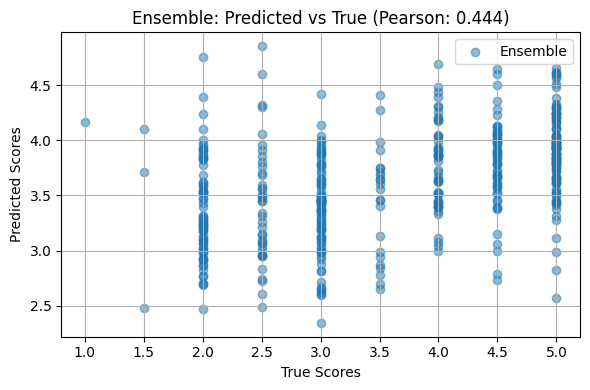

In [14]:
# STEP 13: Visualize
plt.figure(figsize=(6, 4))
plt.scatter(y_train, ensemble_pred, alpha=0.5, label="Ensemble")
plt.xlabel("True Scores")
plt.ylabel("Predicted Scores")
plt.title(f"Ensemble: Predicted vs True (Pearson: {r_ensemble:.3f})")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
